In [43]:
# %pip install matplotlib
# %pip install numpy
# %pip install qutip
# %pip install imageio

In [44]:
import matplotlib as mpl
from pylab import *
from matplotlib import cm
import imageio
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from IPython.display import Image, Math, Latex, display
import PIL

<h2>
    <center>
        General spin echo
    </center>
</h2>

In the rotating wave approximation, and transformed to the rotating frame of the laser, the Hamiltonian of a collection of two-level atoms coupled to a classical light field is 
$$ H = H_{0} + H_{I} + H_{D} $$
where 
$$ H_{0} = \sum_{i} \hbar\Delta_{i} \sigma_{i}^{\dagger} \sigma_{i} $$
$$ H_{D} =  \sum_{i} \Omega_{i} \left(\sigma_{i} + \sigma_{i}^{\dagger}\right). $$
Here, $\hbar\Delta_{i}$ is the transition energy of the $i$th atom in the rotating frame of the laser, $\Omega_{i}$ is the Rabi frequency which quantifies the coupling strength between the atom and the light, and $H_{I}$ contains all interaction terms between the atoms.

If we pulse the laser on and off much faster than the time dynamics of the system, then the drive term $H_{D}$ results in a rotation of the quantum state around the x-axis of the Bloch sphere. The magnitude of $\Omega_{i}$ and the time of the pulse determine the degree of rotation.


In [45]:
def qsum(op_list):
    op = op_list[0]*0
    for op_i in op_list:
        op += op_i
    return op

class N_dipole_system:
    def __init__(self, N):
        # Number of atoms
        self.N = N

        # Operators for a single atom
        idatom = qeye(2)  # identity operator
        sm = projection(2, 0, 1)  # lowering operator

        # Operators for the total system
        self.sm_list = []
        for i in range(N):
            op_list = [idatom] * N
            op_list[i] = sm
            self.sm_list.append(tensor(op_list))
        self.sz_list = [
            -sm.dag() * sm + sm * sm.dag() for sm in self.sm_list
        ]
        self.sx_list = [
            sm + sm.dag() for sm in self.sm_list
        ]
        self.sy_list = [
            1j * (sm - sm.dag()) for sm in self.sm_list
        ]


        # initial states 
        self.ket_excited = tensor([basis(2,1) for _ in range(self.N)])
        self.ket_ground = tensor([basis(2,0) for _ in range(self.N)])

        # total spin operators
        self.id_tot = tensor([qeye(2)] * N)
        self.sm_tot = self.ket_ground * self.ket_excited.dag()
        self.sp_tot = self.sm_tot.dag()
        self.sz_tot = self.sp_tot * self.sm_tot - self.sm_tot * self.sp_tot
        self.sx_tot = self.sp_tot + self.sm_tot

        # list of states
        self.states = []
        self.times = [0]
        self.H = []

    def pulse_sequence(self, tau, theta_list, e_op=None, points_pulse=2, points_evolve=2):
        """
        Runs a sequence of pulses on the system. Between each pulse, the system evolves for a time 'tau'.

        Parameters:
        tau (float): Time for the system to evolve between pulses.
        theta_list (list): List of pulse angles.
        e_op (Qobj, optional): Operator for which the expectation value is calculated. Defaults to ket_excited * ket_excited.dag().
        points_pulse (int, optional): Number of points for computing the wavefunction during the pulse. Defaults to 2.
        points_evolve (int, optional): Number of points for computing the wavefunction during evolution. Defaults to 2.

        Returns:
        float: Expectation value of the operator 'e_op' for the final state.
        """
        if e_op is None:
            e_op = self.ket_excited * self.ket_excited.dag()
        self.states = [self.ket_ground]
        self.times = [0]
        for n, theta in enumerate(theta_list):
            self.evolve_pulse(np.linspace(0,1,points_pulse), Omega=[theta]*self.N)
            if n != len(theta_list) - 1:
                self.evolve(np.linspace(0,tau,points_evolve))
        return expect(e_op, self.states[-1])

    def evolve_pulse(self, tlist, Omega=None, c_ops=[]):
        """
        Evolves the system under a given Hamiltonian for a specified time period during a pulse.

        Parameters:
        tlist (list): List of time points.
        Omega (list, optional): List of Rabi frequencies for each atom. Defaults to [1] * self.N.
        c_ops (list, optional): List of collapse operators. Defaults to an empty list.

        Returns:
        Qobj: The final state of the system after evolution.
        """
        if Omega==None:
          Omega = [1] * self.N
        H = self.H * 0
        for i, sm in enumerate(self.sm_list):
            H += (Omega[i]/2*sm + np.conjugate(Omega[i]/2)*sm.dag())
        psi0 = self.states[-1]
        self.states += mesolve(H, psi0, tlist, c_ops=c_ops).states
        self.times += list(np.array(tlist) + self.times[-1])
        return self.states[-1]

    def evolve(self, tlist, c_ops=[]):
        """
        Evolves the system under the system Hamiltonian for a specified time period.

        Parameters:
        tlist (list): List of time points.
        c_ops (list, optional): List of collapse operators. Defaults to an empty list.

        Returns:
        Qobj: The final state of the system after evolution.
        """
        psi0 = self.states[-1]
        self.states += mesolve(self.H, psi0, tlist, c_ops=c_ops).states
        self.times += list(np.array(tlist) + self.times[-1])
        return self.states[-1]

    def animate_bloch(self, fname, duration=1, save_all=False):
        """
        Generates an animation of the system's states on the Bloch sphere.

        Parameters:
        fname (str): Filename to save the animation.
        duration (float, optional): Duration of each frame in the animation. Defaults to 1.
        save_all (bool, optional): Whether to save all frames. Defaults to False.
        """
        n_states_to_plot = 10
        b = Bloch()
        b.vector_color = list(cm.Set1(np.linspace(0, 1, 9)))
        b.view = [-40,30]
        images=[]
        length = len(self.states)

        ### customize the Bloch sphere ###
        nrm = mpl.colors.Normalize(0,n_states_to_plot+1)
        colors = cm.autumn(nrm(range(n_states_to_plot+1))) # options: cool, summer, winter, autumn etc.
        color_list = [mpl.colors.rgb2hex(c) for c in colors for _ in range(self.N)] # options: 'r', 'g', 'b' etc.
        b.point_color = color_list #['#000000']
        b.point_marker = ['o']
        b.point_size = [30]

        for i in range(length):
            b.clear()
            b.add_states([self.states[i].ptrace(j) for j in range(self.N)])
            for j in range(max(0, i-n_states_to_plot), i+1):
                b.add_states([self.states[j].ptrace(n) for n in range(self.N)],'point')
            if save_all:
                b.save(dirc='tmp') #saving images to tmp directory
                filename="tmp/bloch_%01d.png" % i
            else:
                filename='temp_file.png'
                for _ in range(3):
                    try:
                        b.save(filename)
                        break
                    except:
                        print("Error making bloch sphere at t = ", self.times[i])
            images.append(imageio.imread(filename))
        imageio.mimsave(fname, images, duration=duration, loop=0)

<h2>
    <center>
        A single atom
    </center>
</h2>

Let's consider a single atom. The Hamiltonian is

$$
  H = \Delta \sigma^\dagger \sigma.
$$

We will pulse the system with a $\pi/2$ pulse, which rotates the state $90^\circ$ around the x-axis of the Bloch sphere. We then allong the system to evolve for one time unit and pulse with another $\pi/2$ pulse. The evolution of the Bloch sphere highlights the rotation of the state around the x-axis.

In [46]:
tlist = np.linspace(0, 1, 10)
sys = N_dipole_system(1)
sys.H = sys.sm_list[0].dag() * sys.sm_list[0]  # Hamiltonian
sys.states = [sys.ket_ground]  # initial state
sys.evolve_pulse(tlist, Omega=[np.pi/2])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
sys.evolve(tlist)  # Evolve accoding to sys.H for times in tlist
sys.evolve_pulse(tlist, Omega=[np.pi/2])
sys.animate_bloch('single_atom.gif', duration=5)

C:\Users\chris\AppData\Local\Temp\ipykernel_24108\2803044176.py:151: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


<figure>
    <img src="single_atom.gif" alt="drawing" width="400"/>
</figure>

<h2>
  <center>
    Two atoms driven with different pulse sequences
  </center>
</h2>

We now consider two atoms. The Hamiltonian is

$$
  H = \sum_{i=1}^2 \Delta_i \sigma_i^\dagger \sigma_i.
$$

By passing a list of $\Omega$-values, we can see that the code is capable of rotating each of the states independently about the $x$-axis. 

In [48]:
tlist = np.linspace(0, 1, 10)
sys = N_dipole_system(2)
sys.H = qsum([sz/2 for sz in sys.sz_list])
sys.states = [sys.ket_ground]  # initial state

sys.evolve_pulse(tlist, Omega=[np.pi/2, 0])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
sys.evolve(tlist)
sys.evolve_pulse(tlist, Omega=[0, np.pi])
sys.evolve(tlist)
sys.evolve_pulse(tlist, Omega=[np.pi/2, 0])
sys.animate_bloch('two_atoms.gif', duration=10)

C:\Users\chris\AppData\Local\Temp\ipykernel_24108\2803044176.py:151: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


<figure>
    <img src="two_atoms.gif" alt="drawing" width="400"/>
</figure>

<h2>
    <center>
        Inhomogeneous broadening of six atoms 
    </center>
</h2>

Suppose that we have many non-interacting atoms with different frequencies. The Hamiltonian of the system is

$$
H = \sum_{i}\Delta_{i}\sigma_{i}^{\dagger}\sigma_{i}
$$

We compare two cases. In the first case, we apply a Ramsey sequence, which consists of a $\pi/2$ pulse, a free evolution, and another $\pi/2$ pulse. In the second case, we apply a spin echo sequence, which consists of a $\pi/2$ pulse, a free evolution, a $\pi$ pulse, another free evolution, and a final $\pi/2$ pulse. The spin echo sequence is designed to cancel out the effects of inhomogeneous broadening. We see that the Ramsey sequence is sensitive to the inhomogeneous broadening, while the spin echo sequence is not.

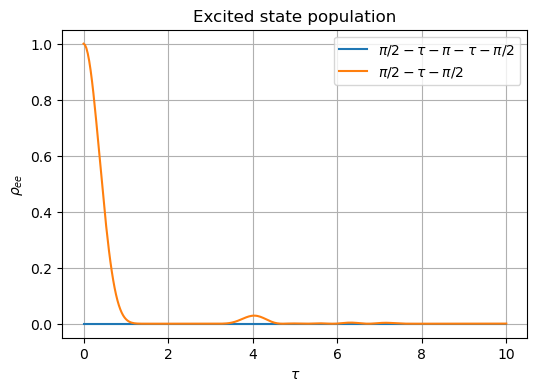

In [50]:
omega = [1, 1.2, 1.4, 1.6, 1.8, 2, 2.2]
tlist = np.linspace(0, 10, 300)
sys = N_dipole_system(6)
sys.H = qsum([omega[i] * sys.sm_list[i].dag() * sys.sm_list[i] for i in range(sys.N)])

rho_e_ramsey = [sys.pulse_sequence(t, [np.pi/2, np.pi, np.pi/2]) for t in tlist]
rho_e_not_ramsey = [sys.pulse_sequence(t, [np.pi/2, np.pi/2]) for t in tlist]

plt.figure(figsize=(6,4))
plt.plot(tlist, rho_e_ramsey, label=r'$\pi/2-\tau-\pi-\tau-\pi/2$')
plt.plot(tlist, rho_e_not_ramsey, label=r'$\pi/2-\tau-\pi/2$')
plt.grid(True)
plt.title('Excited state population')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\rho_{ee}$')
plt.legend(loc='upper right')

In [51]:
omega = [1, 1.2, 1.4, 1.6, 1.8, 2, 2.2]
sys = N_dipole_system(6)
sys.H = qsum([omega[i] * sys.sm_list[i].dag() * sys.sm_list[i] for i in range(sys.N)])
sys.pulse_sequence(4, [np.pi/2, np.pi, np.pi/2], points_pulse=20, points_evolve=40)
sys.animate_bloch('inhomogeneous_spin_echo.gif', duration=60)

C:\Users\chris\AppData\Local\Temp\ipykernel_24108\2803044176.py:151: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


<figure>
    <img src="inhomogeneous_spin_echo.gif" alt="drawing" width="400"/>
</figure>

In [66]:
omega = [1, 1.2, 1.4, 1.6, 1.8, 2, 2.2]
sys = N_dipole_system(6)
sys.H = qsum([omega[i] * sys.sm_list[i].dag() * sys.sm_list[i] for i in range(sys.N)])
sys.pulse_sequence(4, [np.pi/2, np.pi/2], points_pulse=20, points_evolve=40)
sys.animate_bloch('inhomogeneous_ramsey.gif', duration=60)

C:\Users\chris\AppData\Local\Temp\ipykernel_24108\2803044176.py:151: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


<figure>
    <img src="inhomogeneous_ramsey.gif" alt="drawing" width="400"/>
</figure>


<h2>
    <center>
        Dynamic decoupling of two interacting atoms
    </center>
</h2>

Suppose a system is coupled to a bath via a Hamiltonian $H_{B}$. For example, $H_{B}$ might be something like $\Gamma\sigma$, which describes decay of an atomic state at a rate of $\Gamma$. The evolution of the system is given in this case by 

$$
\begin{align*}
    \left|\psi^{\prime}\right\rangle &= e^{-i\Gamma\sigma t}\left|\psi\right\rangle.
\end{align*}
$$

We now consider a $\pi$-pulse operator which rotates a state around the x-axis of the Bloch sphere. This operator is proportional to $\sigma_{x}$. A spin-echo sequence is represented by a sequence of $\sigma_{x}$ operations and time evolutions

$$
\begin{align*}
    \left|\psi^{\prime}\right\rangle &= e^{-i\Gamma\sigma t}\sigma_{x}e^{-i\Gamma\sigma t}\sigma_{x}\left|\psi\right\rangle.
\end{align*}
$$

We can expand the second exponential to obtain

$$
\begin{align*}
    \left|\psi^{\prime}\right\rangle &= e^{-i\Gamma\sigma t}\sum_{n}\frac{\left(-i\Gamma\right)^{n}}{n!}\sigma_{x}\sigma^{n}\sigma_{x}\left|\psi\right\rangle.
\end{align*}
$$

Because $\sigma_{x}^{2} = \mathbb{I}$, we can see that 

$$
\begin{align*}
    \sigma_{x}\sigma^{n}\sigma_{x} &= \left(\sigma_{x}\sigma\sigma_{x}\right)\left(\sigma_{x}\sigma\sigma_{x}\right)\cdots = \left(\sigma_{x}\sigma\sigma_{x}\right)^{n},
\end{align*}
$$

such that 

$$
\begin{align*}
    \left|\psi^{\prime}\right\rangle &= e^{-i\Gamma\sigma t}\sum_{n}\frac{\left(-i\Gamma\right)^{n}}{n!}\left(\sigma_{x}\sigma\sigma_{x}\right)^{n}\left|\psi\right\rangle \\
    &= e^{-i\Gamma\sigma t}e^{-i\Gamma\sigma_{x}\sigma\sigma_{x}t}\left|\psi\right\rangle.
\end{align*}
$$

Using that 

$$
\begin{align*}
    \sigma_{x} &= \left(\begin{array}{cc}
    0 & 1 \\
    1 & 0
    \end{array}\right), \\
    \sigma &= \left(\begin{array}{cc}
    0 & 0 \\
    1 & 0
    \end{array}\right),
\end{align*}
$$

we can easily see that 

$$
\begin{align*}
e^{-i\Gamma\sigma_{x}^{\dagger}\sigma\sigma_{x}}&=e^{-i\Gamma\sigma^{\dagger}}
\end{align*}
$$

The result is that the sequence of $\pi$-pulses cancels out the coupling with the bath, such that

$$
\begin{align*}
\left|\psi^{\prime}\right\rangle  &=e^{-i\Gamma\sigma t}e^{-i\Gamma\sigma^{\dagger}t}\left|\psi\right\rangle .
\end{align*}
$$

This describes a process where the quantum state first evolves according to the raising operator $\sigma^{\dagger}$, and then the lowering operator. This treatment does not include evolution according to the system Hamiltonian. Nevertheless, it illustrates that, for certain interactions, a sequence of rapid $\pi$-pulses can cancel the evolution. 

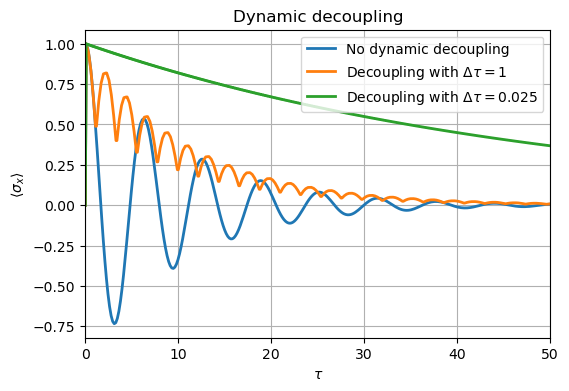

In [54]:
tlist = np.linspace(0, 50, 300)
tlist_pulse = [0,.1]
gamma = 0.2
omega = [1, 1]
sys = N_dipole_system(1)
e_op = sys.sx_list[0]

### No dynamic decoupling ###
sys.H = qsum([omega[i] * si.dag() * si for i, si in enumerate(sys.sm_list)]) 
sys.states = [basis(2,0)]  # initial state
sys.times = [0]

# pulse sequence
sys.evolve_pulse(tlist_pulse, Omega=[-1j*np.pi/2/tlist_pulse[-1]])
sys.evolve(tlist, c_ops=[np.sqrt(gamma)*sys.sm_list[0]])
t0 = sys.times
e0 = [expect(e_op, s) for s in sys.states]

# Dynamic decoupling Delta tau = 1
tlist = np.linspace(0, 1., 5)
sys.H = qsum([omega[i] * si.dag() * si for i, si in enumerate(sys.sm_list)]) 
sys.states = [basis(2,0)]  # initial state
sys.times = [0]

# pulse sequence
sys.evolve_pulse(tlist_pulse, Omega=[-1j*np.pi/2/tlist_pulse[-1]])
sys.evolve(tlist, c_ops=[np.sqrt(gamma)*sys.sm_list[0]])
for _ in range(50):
        sys.evolve_pulse(tlist_pulse, Omega=[np.pi/tlist_pulse[-1]])
        sys.evolve(tlist, c_ops=[np.sqrt(gamma)*sys.sm_list[0]])
t1 = sys.times
e1 = [expect(e_op, s) for s in sys.states]

# Dynamic decoupling Delta tau = 0.025
tlist = np.linspace(0, 0.025, 5)
sys.H = qsum([omega[i] * si.dag() * si for i, si in enumerate(sys.sm_list)]) 
sys.states = [basis(2,0)]  # initial state
sys.times = [0]

# pulse sequence
sys.evolve_pulse(tlist_pulse, Omega=[-1j*np.pi/2/tlist_pulse[-1]])
sys.evolve(tlist, c_ops=[np.sqrt(gamma)*sys.sm_list[0]])
for _ in range(400):
        sys.evolve_pulse(tlist_pulse, Omega=[np.pi/tlist_pulse[-1]])
        sys.evolve(tlist, c_ops=[np.sqrt(gamma)*sys.sm_list[0]])
t2 = sys.times
e2 = [expect(e_op, s) for s in sys.states]

plt.figure(figsize=(6,4))
plt.plot(t0, e0, '-', lw=2, label=r'No dynamic decoupling')
plt.plot(t1, e1, '-', lw=2, label=r'Decoupling with $\Delta \tau = 1$')
plt.plot(t2, e2, '-', lw=2, label=r'Decoupling with $\Delta \tau = 0.025$')
plt.grid(True)
plt.title('Dynamic decoupling')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\left<\sigma_x\right>$')
plt.legend(loc='upper right')
plt.xlim(0, 50)
plt.savefig('dynamic_decoupling.png', dpi=300, bbox_inches='tight')

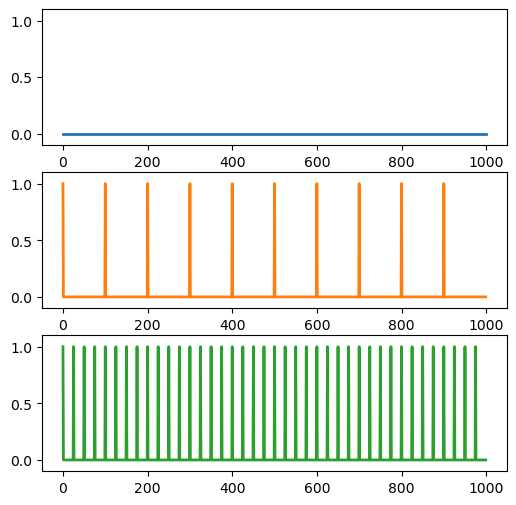

In [55]:
### Visualization of pulses ###
normal_decay = [0] * 1000
decoupling_1 = [1 if i%100==0 else 0 for i in range(1000)]
decoupling_2 = [1 if i%25==0 else 0 for i in range(1000)]

fig, ax = plt.subplots(3,1,figsize=(6,6))
ax[0].plot(normal_decay, lw=2, label='No decoupling', color='tab:blue')
ax[0].set_ylim(-0.1, 1.1)
ax[1].plot(decoupling_1, lw=2, label='Decoupling with $\Delta \tau = 1$', color='tab:orange')
ax[1].set_ylim(-0.1, 1.1)
ax[2].plot(decoupling_2, lw=2, label='Decoupling with $\Delta \tau = 0.025$', color='tab:green')
ax[2].set_ylim(-0.1, 1.1)

fig.savefig('dynamic_decoupling_pulses.png', dpi=300, bbox_inches='tight')

In [56]:
tlist = np.linspace(0, 10, 30)
tlist_pulse = [0,.1]
gamma = 0.2
omega = [1, 1]
sys = N_dipole_system(1)

### Noynamic decoupling ###
sys.H = qsum([omega[i] * si.dag() * si for i, si in enumerate(sys.sm_list)]) 
sys.states = [basis(2,0)]  # initial state

# pulse sequence
sys.evolve_pulse(tlist_pulse, Omega=[-1j*np.pi/2/tlist_pulse[-1]])
sys.evolve(tlist, c_ops=[np.sqrt(gamma)*sys.sm_list[0]])
sys.evolve(tlist, c_ops=[np.sqrt(gamma)*sys.sm_list[0]])

sys.animate_bloch('no_dynamic_decoupling.gif', duration=60)

C:\Users\chris\AppData\Local\Temp\ipykernel_24108\2803044176.py:151: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


<figure>
    <img src="no_dynamic_decoupling.gif" alt="drawing" width="400"/>
</figure>

In [58]:
tlist = np.linspace(0,0.1, 5)
tlist_pulse = [0,.1]
gamma = 0.2
omega = [1, 1]
sys = N_dipole_system(1)

### Noynamic decoupling ###
sys.H = qsum([omega[i] * si.dag() * si for i, si in enumerate(sys.sm_list)]) 
sys.states = [basis(2,0)]  # initial state

# pulse sequence
sys.evolve_pulse(tlist_pulse, Omega=[-1j*np.pi/2/tlist_pulse[-1]])
sys.evolve(tlist, c_ops=[np.sqrt(gamma)*sys.sm_list[0]])
for _ in range(50):
        sys.evolve_pulse(tlist_pulse, Omega=[np.pi/tlist_pulse[-1]])
        sys.evolve(tlist, c_ops=[np.sqrt(gamma)*sys.sm_list[0]])

sys.animate_bloch('dynamic_decoupling.gif', duration=60)

C:\Users\chris\AppData\Local\Temp\ipykernel_24108\2803044176.py:151: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


<figure>
    <img src="dynamic_decoupling.gif" alt="drawing" width="400"/>
</figure>

<h2>
    <center>
        Pulse sequences in the presence of interaction
    </center>
</h2>

We consider a system of two atoms with an interaction term proportional to $\sigma_{z}^{0}\sigma_{z}^{1}$. We can begin by applying a Ramsey sequence for both spins. 

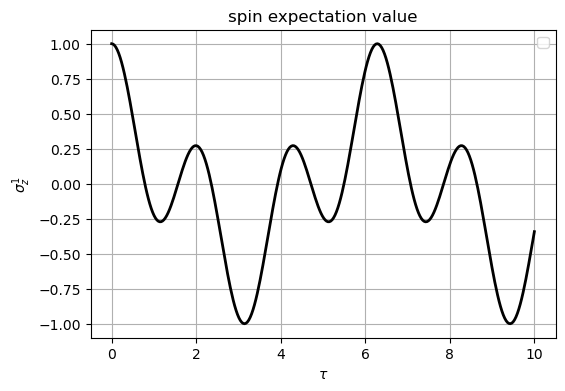

In [60]:
tlist = np.linspace(0, 10, 300)
omega = [1,1]
sys = N_dipole_system(2)

sys.H =  omega[0]/2*sys.sz_list[0] + omega[1]/2*sys.sz_list[1] + 1*sys.sz_list[0]*sys.sz_list[1]
sys.states = [sys.ket_excited]  # initial state

e_op = sys.sz_list[0] 
observables = []

for t in tlist:
    sys.states = [sys.ket_excited]  # initial state
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])
    observables.append([expect(e_op, sys.states[-1])])

plt.figure(figsize=(6,4))
plt.plot(tlist, observables, lw=2, color='black')
plt.grid(True)
plt.title('spin expectation value')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^{1}_{z}$')
plt.legend(loc='upper right')

In [61]:
sys.states = [sys.ket_excited]  # initial state
sys.evolve_pulse(np.linspace(0,1,5), Omega=[np.pi/2, np.pi/2])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
sys.evolve(np.linspace(0,t,50))
sys.evolve_pulse(np.linspace(0,1,5), Omega=[np.pi/2, np.pi/2])

sys.animate_bloch('Ramsey_yupeng.gif', duration=200)

C:\Users\chris\AppData\Local\Temp\ipykernel_24108\2803044176.py:151: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


<figure>
    <img src="Ramsey_yupeng.gif" alt="drawing" width="400"/>
</figure>

We can apply spin echo sequence for both spins. Note that $\sigma_z^1\sigma_z^2$ is preserved but $\sigma_z^1$ and $\sigma_z^2$ are not.

Importantly, the frequency of $\sigma_z^1$ and $\sigma_z^2$ are dependent on interaction strength not the spin frequencies.

Another notable point is that $\langle\sigma_z^1\sigma_z^2\rangle$ is not simply the product of $\langle\sigma_z^1\rangle$ and $\langle\sigma_z^2\rangle$.

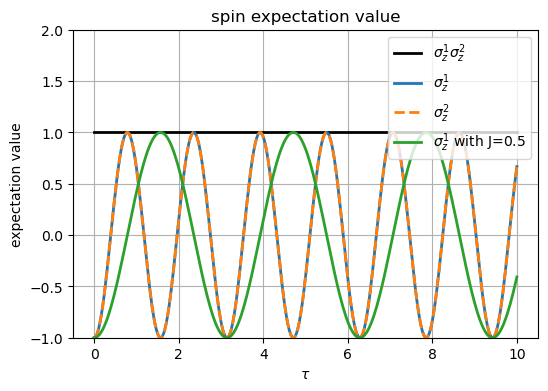

In [63]:
tlist = np.linspace(0, 10, 300)
omega = [1,1]
sys = N_dipole_system(2)

sys.H =  omega[0]/2*sys.sz_list[0] + omega[1]/2*sys.sz_list[1] + 1*sys.sz_list[0]*sys.sz_list[1]
sys.states = [sys.ket_excited]  # initial state

e_op = [sys.sz_list[0]*sys.sz_list[1],sys.sz_list[0],sys.sz_list[1]]
observables0 = []
observables1 = []
observables2 = []

for t in tlist:
    sys.states = [sys.ket_excited]  # initial state
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi, np.pi])
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])
    observables0.append([expect(e_op[0], sys.states[-1])])
    observables1.append([expect(e_op[1], sys.states[-1])])
    observables2.append([expect(e_op[2], sys.states[-1])])



sys.H =  omega[0]/2*sys.sz_list[0] + omega[1]/2*sys.sz_list[1] + 0.5*sys.sz_list[0]*sys.sz_list[1]
sys.states = [sys.ket_excited]  # initial state

e_op = [sys.sz_list[0]*sys.sz_list[1],sys.sz_list[0],sys.sz_list[1]]
observables3 = []

for t in tlist:
    sys.states = [sys.ket_excited]  # initial state
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi, np.pi])
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])
    observables3.append([expect(e_op[1], sys.states[-1])])



plt.figure(figsize=(6,4))
plt.plot(tlist, observables0, lw=2, label='$\sigma_z^1\sigma_z^2$', color='black')
plt.plot(tlist, observables1, lw=2, label='$\sigma_z^1$')
plt.plot(tlist, observables2, '--', lw=2, label='$\sigma_z^2$')
plt.plot(tlist, observables3, lw=2, label='$\sigma_z^1$ with J=0.5')

plt.ylim(-1,2)
plt.grid(True)
plt.title('spin expectation value')
plt.xlabel(r'$\tau$')
plt.ylabel(r'expectation value')
plt.legend(loc='upper right')


Is it possible to extract the frequency of first spin using some sequence? 

Intuitively, we choose a pulse sequence '$\frac{\pi}{2}$ - evolve - $\frac{\pi}{2}$' for the first spin and 'evolve - $\pi$ - evolve' for the second spin and measure $\sigma_z$ for the first atom. 

We find that $\langle\sigma_z^1\rangle$ is invariant under different interaction strength J, though it is twice the frequence of the spin.

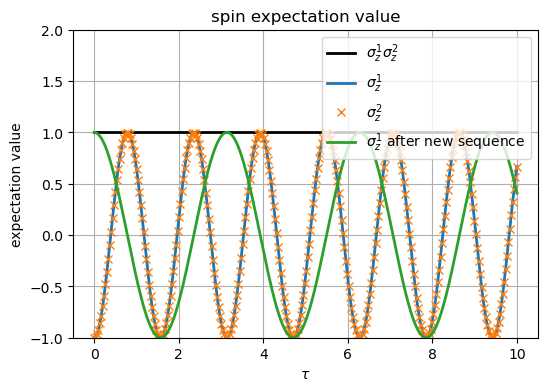

In [64]:
tlist = np.linspace(0, 10, 300)
omega = [1,1]
sys = N_dipole_system(2)

sys.H =  omega[0]/2*sys.sz_list[0] + omega[1]/2*sys.sz_list[1] + 1*sys.sz_list[0]*sys.sz_list[1]
sys.states = [sys.ket_excited]  # initial state

e_op = [sys.sz_list[0]*sys.sz_list[1],sys.sz_list[0],sys.sz_list[1]]
observables0 = []
observables1 = []
observables2 = []

for t in tlist:
    sys.states = [sys.ket_excited]  # initial state
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi, np.pi])
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, np.pi/2])
    observables0.append([expect(e_op[0], sys.states[-1])])
    observables1.append([expect(e_op[1], sys.states[-1])])
    observables2.append([expect(e_op[2], sys.states[-1])])



sys.H =  omega[0]/2*sys.sz_list[0] + omega[1]/2*sys.sz_list[1] + 6*sys.sz_list[0]*sys.sz_list[1]
sys.states = [sys.ket_excited]  # initial state

observables3 = []

for t in tlist:
    sys.states = [sys.ket_excited]  # initial state
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, 0])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[0, np.pi])
    sys.evolve(np.linspace(0,t,2))
    sys.evolve_pulse(np.linspace(0,1,2), Omega=[np.pi/2, 0])
    observables3.append([expect(e_op[0], sys.states[-1])])


    
plt.figure(figsize=(6,4))
plt.plot(tlist, observables0, lw=2, label='$\sigma_z^1\sigma_z^2$', color='black')
plt.plot(tlist, observables1, lw=2, label='$\sigma_z^1$')
plt.plot(tlist, observables2, 'x', lw=2, label='$\sigma_z^2$')
plt.plot(tlist, observables3, lw=2, label='$\sigma_z^1$ after new sequence')

plt.ylim(-1,2)
plt.grid(True)
plt.title('spin expectation value')
plt.xlabel(r'$\tau$')
plt.ylabel(r'expectation value')
plt.legend(loc='upper right')
